In [1]:
import platform
platform.architecture()

('64bit', 'WindowsPE')

In [2]:
import  pandas  as  pd
import  numpy   as  np
import  re, nltk
from    nltk.stem                       import  WordNetLemmatizer
from    nltk.corpus                     import  stopwords
from    sklearn.feature_extraction.text import  CountVectorizer,TfidfTransformer
from    sklearn.naive_bayes             import  BernoulliNB,GaussianNB, MultinomialNB
from    pprint                          import  pprint
import  matplotlib.pyplot               as  plt
import  itertools
from    sklearn.metrics                 import  confusion_matrix,accuracy_score
from    sklearn.svm                     import  LinearSVC,  NuSVC,  SVC
from    sklearn.neighbors               import KNeighborsClassifier
from    sklearn.tree                    import DecisionTreeClassifier        as Tree

## Parte 3 Análisis de emociones en tweets

#### (a) Construya un dataframe con los datos a analizar. Determine cu´antas clases existen, cu´antos registros por clase y describa el *dataset*.

In [3]:
df = pd.read_csv("text_emotion.csv")

In [4]:
#pd.crosstab(df['author'],df['sentiment'],margins=True)

In [5]:
df.head()

,tweet_id,sentiment,author,content
0,1956967341,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1956968416,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


Dado a que tweet_id no representa valor para nuestros intereses, se dropea esta columna del dataframe

In [6]:
df.drop(['tweet_id'],axis=1,inplace=True)

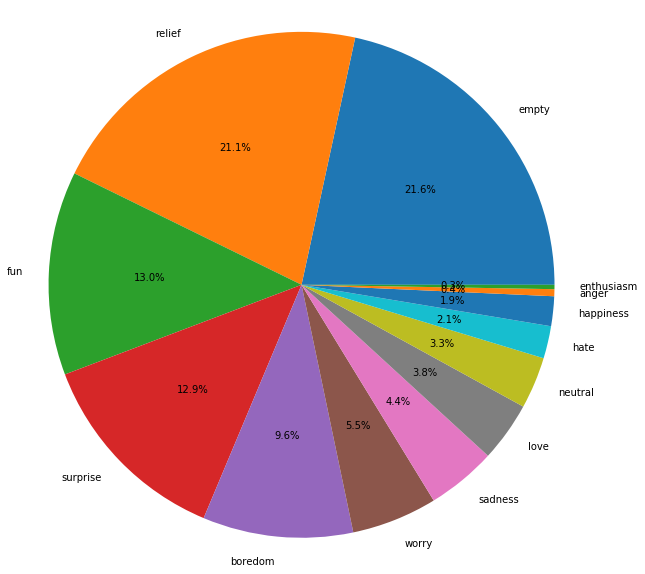

In [7]:
sentiment_counts = df['sentiment'].value_counts()
#print sentiment_counts
#print list(set(df.sentiment.values))
plt.figure(figsize=(10,10))
plt.pie(sentiment_counts,labels=list(set(df.sentiment.values)),autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Dado a la distrubución de las clases para un caso multi labels se puede notar que el clasificador aprendera más de un tipo que otro pudiendo provocar errores de clasificación entre otras clases.

#### (b) Construya un conjunto de entrenamiento y otro de pruebas, a trav´es de una m´ascara aleatoria, para verificar los resultados de los algoritmos.

In [11]:

msk = np.random.rand(len(df)) < 0.8
train = pd.DataFrame(df[msk])
test = pd.DataFrame(df[~msk])

(c)	Implemente y explique un pre-procesamiento para los tweets para dejarlos en un formato est´andarizado en el cual se podr´an trabajar.

In [12]:
#preproccesing functions
def coding(col,codeDict):
    colCoded = pd.Series(col,copy=True)
    for key,value in codeDict.items():
        colCoded.replace(key,value,inplace=True)
    return colCoded
#Recibe una columna que seran los atributos a codificar y un diccionario que sera los datos como 
#codificara las etiquetas

In [13]:
#estandarizacion del texto en la columna content mediante liberias de re y nlt
stop_words = set(stopwords.words('english'))
wordnet_lemmatizer = WordNetLemmatizer()

#Cambia el texto de cualquier forma presente a minusculas
def normalizer(content):
    without_user_name = re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))@([A-Za-z]+[A-Za-z0-9]+)"," ",content)
    without_links = re.sub("https?:\/\/.*[\r\n]*"," ",without_user_name)
    #short_words = re.sub("\b\w\b"," ",without_links)
    #without_hashtags = re.sub("(?<=^|(?<=[^a-zA-Z0-9-_\.]))#([A-Za-z]+[A-Za-z0-9]+)"," ",without_links)
    only_letters = re.sub("[^a-zA-Z]", " ",without_links) 
    tokens = nltk.word_tokenize(only_letters)
    lower_case = [l.lower() for l in tokens]
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))
    lemmas = [wordnet_lemmatizer.lemmatize(t,pos='v') for t in filtered_result]
    return lemmas


In [14]:
pd.set_option('display.max_colwidth', -1) # Setting this so we can see the full content of cells
train['normalized_tweet'] = train.content.apply(normalizer)
test['normalized_tweet'] = test.content.apply(normalizer)

In [15]:
train[['content','normalized_tweet']].head(10)

,content,normalized_tweet
0,@tiffanylue i know i was listenin to bad habit earlier and i started freakin at his part =[,"[know, listenin, bad, habit, earlier, start, freakin, part]"
3,wants to hang out with friends SOON!,"[want, hang, friends, soon]"
7,Hmmm. http://www.djhero.com/ is down,[hmmm]
8,@charviray Charlene my love. I miss you,"[charlene, love, miss]"
10,cant fall asleep,"[cant, fall, asleep]"
11,Choked on her retainers,"[choke, retainers]"
12,Ugh! I have to beat this stupid song to get to the next rude!,"[ugh, beat, stupid, song, get, next, rude]"
13,@BrodyJenner if u watch the hills in london u will realise what tourture it is because were weeks and weeks late i just watch itonlinelol,"[u, watch, hill, london, u, realise, tourture, weeks, weeks, late, watch, itonlinelol]"
14,Got the news,"[get, news]"
17,So sleepy again and it's not even that late. I fail once again.,"[sleepy, even, late, fail]"


#### (d)	Haga una reducci´on binaria al problema, para trabajarlo como un problema de clasificaci´on de dos clases. Para esto, agrupe las distintas emociones como positivas y negativas (defina un criterio), se recomienda codificar las clases como +1 y −1 respectivamente. Recuerde tener presente que el desbalanceo de los datos puede afectar considerablemente al modelo.

In [13]:
dictionary = {"anger": -1.0,"boredom": -1.0,"empty": -1.0,"enthusiasm": 1.0,
              "fun": 1.0,"happiness": 1.0,"hate": -1.0,"love": 1.0,"neutral": 1.0,
              "relief": 1.0,"sadness": -1.0,"surprise" : -1.0,"worry": -1.0}
train['sentiment'] = coding(train['sentiment'],dictionary)
dictionary = {"anger": -1.0,"boredom": -1.0,"empty": -1.0,"enthusiasm": 1.0,
              "fun": 1.0,"happiness": 1.0,"hate": -1.0,"love": 1.0,"neutral": 1.0,
              "relief": 1.0,"sadness": -1.0,"surprise" : -1.0,"worry": -1.0}
test['sentiment'] = coding(test['sentiment'],dictionary)


 1.0    17429
-1.0    14639
Name: sentiment, dtype: int64


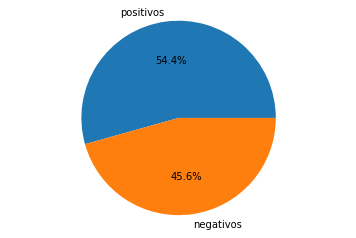

In [14]:
sentiment_counts = train['sentiment'].value_counts()
print (sentiment_counts)
plt.pie(sentiment_counts,labels=['positivos','negativos'],autopct='%1.1f%%')
plt.axis('equal')
plt.show()

Dada esta codificación las cantidades entre tweet positivos y tweet negativos quedaron equiparables para su uso

#### (e)	Para construir un clasificador que determine autom´aticamente la polaridad de un trozo de texto, ser´a necesario representar los tweets $\{t_{i}\}^{n}_{i=1}$ disponibles como vectores de caracter´ısticas (features). El tipo de caracter´ısticas m´as utilizado consiste en contar cu´antas veces aparecen ciertos t´erminos/palabras en el texto. Para esto, es necesario un vocabulario que, por lo general, se construye mediante la uni´on de todas las palabras que se observen en los tweets.

In [15]:
traindata = [" ".join(x) for x in train.normalized_tweet]
testdata = [" ".join(x) for x in test.normalized_tweet]

train_label = train.sentiment
test_label = test.sentiment

Dado al formato que tiene la data despues de pasar por la normalizacion de esta, se adapta para poder coincidir con el formato que acepta countVectorizer

In [16]:
count_vec = CountVectorizer(lowercase = False)
count_vec.fit(traindata)

Xtrain = count_vec.transform(traindata)
Xtest = count_vec.transform(testdata)

print (Xtrain.shape)
print (Xtest.shape)

(32068, 22603)
(7932, 22603)


In [17]:
tf_transformer = TfidfTransformer(use_idf=False).fit(Xtrain)
Xtrain_tf = tf_transformer.transform(Xtrain)
print (Xtrain_tf.shape)
Xtest_tf = tf_transformer.transform(Xtest)
print (Xtest_tf.shape)

(32068, 22603)
(7932, 22603)


#### (f)	Entrene y compare al menos 5 de los diferentes clasificadores vistos en clases para clasificaci´on binaria (por ejemplo: Navie Bayes, Multinomial Naive Bayes, LDA, QDA, Regresi´on log´ıstica, SVM y Arboles de decisi´on) sobre el conjunto de entrenamiento verificando su desempen˜o sobre ambos conjuntos (entrenamiento y de pruebas), construyendo un gr´afico resumen del error de ´estos

In [9]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [10]:
def errs_(model,x,y,xt,yt): 
    yhat = model.predict(x)
    err = accuracy_score(y,yhat)
    yhat_test = model.predict(xt)
    err_t = accuracy_score(yt,yhat_test)
    return err, err_t

errores = {}

Una matriz de confusión es una herramienta que permite la visualización del desempeño de un algoritmo que se emplea en aprendizaje supervisado. Cada columna de la matriz representa el número de predicciones de cada clase, mientras que cada fila representa a las instancias en la clase real. Uno de los beneficios de las matrices de confusión es que facilitan ver si el sistema está confundiendo dos clases

Bernoulli accuracy score
0.686207766011
Confusion matrix, without normalization


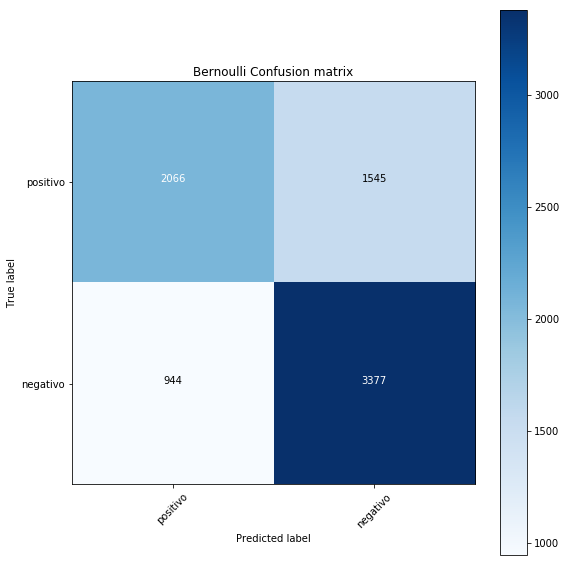

In [59]:
bnb= BernoulliNB()
#fitting
bnb.fit(Xtrain_tf, train_label)
#ypred
ypredBnb = bnb.predict(Xtest_tf)
#print (ypredBnb.shape)
#print (test_label.shape)
print ('Bernoulli accuracy score')
print (accuracy_score(test_label, ypredBnb))
#errores['Bernoulli']=[accuracy_score(test_label, ypredBnb)]
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label, ypredBnb), classes=['positivo','negativo'],
                      title='Bernoulli Confusion matrix')

plt.show()

In [61]:
errores["Bernoulli"] = errs_(bnb,Xtrain_tf,train_label,Xtest_tf,test_label)

Multinomial accuracy score
0.684694906707
Confusion matrix, without normalization


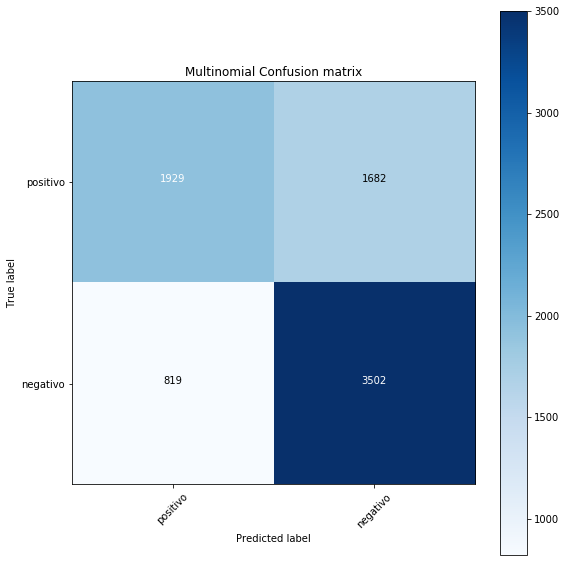

In [63]:
mnb= MultinomialNB()
#fitting
mnb.fit(Xtrain_tf, train_label)
#ypred
ypredmnb = mnb.predict(Xtest_tf)
print ('Multinomial accuracy score')
print (accuracy_score(test_label, ypredmnb))
#errores['Multinomial']=[accuracy_score(test_label, ypredmnb)]
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label, ypredmnb), classes=['positivo','negativo'],
                      title='Multinomial Confusion matrix')

plt.show()

In [64]:
errores["Multinomial"] = errs_(mnb,Xtrain_tf,train_label,Xtest_tf,test_label)

In [65]:
from sklearn.linear_model import LogisticRegression
C_array = [0.01,0.1,0.7,0.8,1,10,100,1000]
best = 0.0
c_b = 0.01
for C in C_array:
    lr = LogisticRegression(penalty='l2',C=C)
    lr.fit(Xtrain_tf, train_label)
    ypredlr = lr.predict(Xtest_tf)
    print ('Logistic Regression accuracy score C= %f'%C)
    acc = accuracy_score(test_label, ypredlr)
    print (acc)
    if(acc > best):
        best = acc
        ypredlr_b = ypredlr
    

Logistic Regression accuracy score C= 0.010000
0.632501260716
Logistic Regression accuracy score C= 0.100000
0.680156328795
Logistic Regression accuracy score C= 0.700000
0.689989914271
Logistic Regression accuracy score C= 0.800000
0.690242057489
Logistic Regression accuracy score C= 1.000000
0.689611699445
Logistic Regression accuracy score C= 10.000000
0.68255168936
Logistic Regression accuracy score C= 100.000000
0.652672718104
Logistic Regression accuracy score C= 1000.000000
0.633888048411


In [66]:
errores["LR"] = errs_(lr,Xtrain_tf,train_label,Xtest_tf,test_label)

Confusion matrix, without normalization


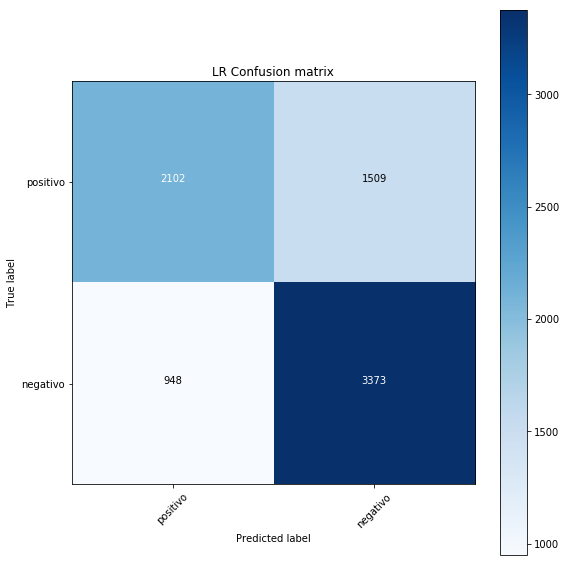

In [67]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label, ypredlr_b), classes=['positivo','negativo'],
                      title='LR Confusion matrix')

plt.show()

Linear Svm accuracy score
0.680408472012
Confusion matrix, without normalization


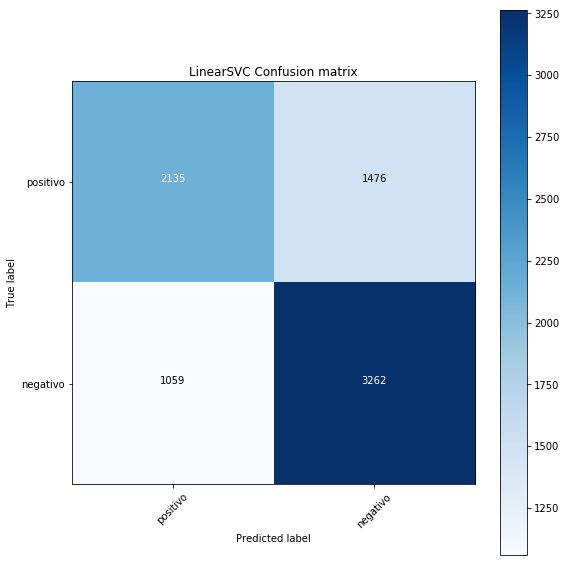

In [70]:
lsvm= LinearSVC()
#fitting
lsvm.fit(Xtrain_tf, train_label)
#ypred
ypredlsvm = lsvm.predict(Xtest_tf)
print ('Linear Svm accuracy score')
print (accuracy_score(test_label, ypredlsvm))
#errores['LinearSVM']=[accuracy_score(test_label, ypredlsvm)]
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label, ypredlsvm), classes=['positivo','negativo'],
                      title='LinearSVC Confusion matrix')

plt.show()

In [71]:
errores["LinearSVC"] = errs_(lsvm,Xtrain_tf,train_label,Xtest_tf,test_label)

Non Linear svm accuracy score
0.672718103883
Confusion matrix, without normalization


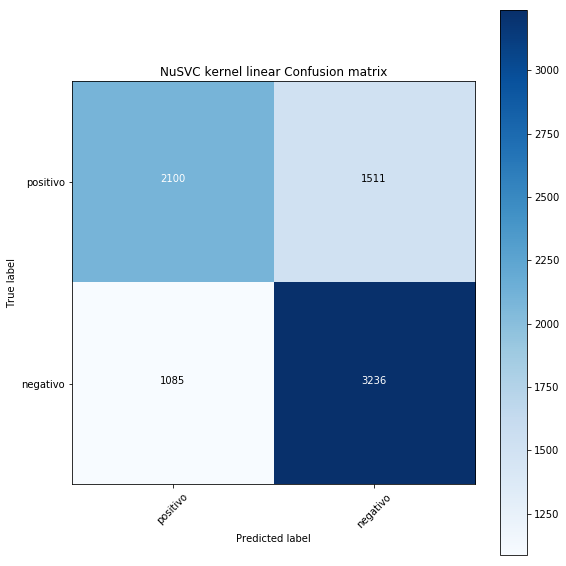

In [72]:
nusvm=NuSVC(kernel='linear',cache_size=800)
#fitting
nusvm.fit(Xtrain_tf, train_label)
#ypred
ypredNusvm = nusvm.predict(Xtest_tf)
print ('Non Linear svm accuracy score')
print (accuracy_score(test_label, ypredNusvm))
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label, ypredNusvm), classes=['positivo','negativo'],
                      title='NuSVC kernel linear Confusion matrix')

plt.show()

In [73]:
errores["NUSVCk=linear"] = errs_(nusvm,Xtrain_tf,train_label,Xtest_tf,test_label)

Non Linear poly svm accuracy score
0.477811396873
Confusion matrix, without normalization


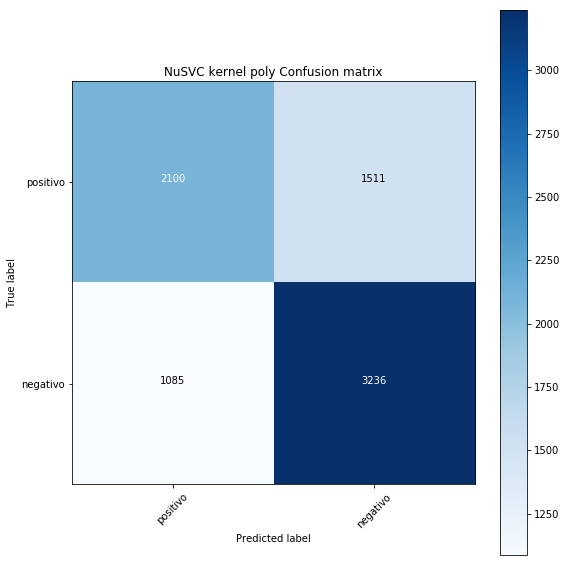

In [74]:
nusvmpoly=NuSVC(kernel='poly',cache_size=800)
#fitting
nusvmpoly.fit(Xtrain_tf, train_label)
#ypred
ypredNusvmpoly = nusvmpoly.predict(Xtest_tf)
print ('Non Linear poly svm accuracy score')
print (accuracy_score(test_label, ypredNusvmpoly))
#errores['NonLinearPoly']=[accuracy_score(test_label, ypredNusvmpoly)]
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label, ypredNusvm), classes=['positivo','negativo'],
                      title='NuSVC kernel poly Confusion matrix')

plt.show()

In [75]:
errores["NuSVCk=poly"] = errs_(nusvmpoly,Xtrain_tf,train_label,Xtest_tf,test_label)

Non Linear rbf svm accuracy score
0.477811396873
Confusion matrix, without normalization


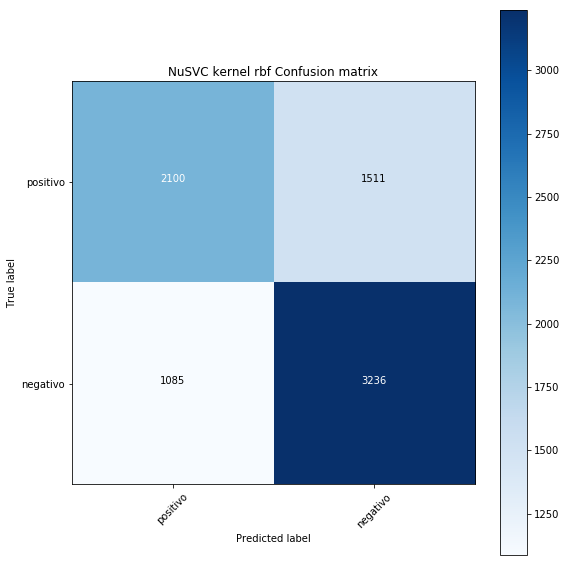

In [76]:
nusvmrbf=NuSVC(kernel='rbf',cache_size=800)
#fitting
nusvmrbf.fit(Xtrain_tf, train_label)
#ypred
ypredNusvmrbf = nusvmpoly.predict(Xtest_tf)
print ('Non Linear rbf svm accuracy score')
print (accuracy_score(test_label, ypredNusvmrbf))
#errores['NonLinearRbf']=accuracy_score(test_label, ypredNusvmrbf)
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label, ypredNusvm), classes=['positivo','negativo'],
                      title='NuSVC kernel rbf Confusion matrix')

plt.show()

In [77]:
errores["NuSVCk=rbf"] = errs_(nusvmrbf,Xtrain_tf,train_label,Xtest_tf,test_label)

Debido al tiempo de ejecución de los NuSVC, solo se uso los parametros automaticos de cada tipo

In [78]:
C_array = [10,100,1000,10000]
best = 0.0
c_b = 0.01
for C in C_array:
    svcrbf = SVC(C=C,kernel='rbf')
    svcrbf.fit(Xtrain_tf, train_label)
    ypredsvcp = svcrbf.predict(Xtest_tf)
    print ('SVC accuracy score C= %f'%C)
    acc = accuracy_score(test_label, ypredsvcp)
    print (acc)
    if(acc > best):
        best = acc
        ypredsvcp_b = ypredsvcp
    

SVC accuracy score C= 10.000000
0.544755421079
SVC accuracy score C= 100.000000
0.567826525466
SVC accuracy score C= 1000.000000
0.674735249622
SVC accuracy score C= 10000.000000
0.692637418053


In [79]:
errores["SVC"] = errs_(svcrbf,Xtrain_tf,train_label,Xtest_tf,test_label)

In [81]:
#print(errores)

{'Bernoulli': (0.80475863789447422, 0.68620776601109434), 'Multinomial': (0.78096544842210303, 0.68469490670700961), 'LR': (0.89977547711113881, 0.63388804841149771), 'LinearSVC': (0.84242858924784836, 0.68040847201210286), 'NUSVCk=linear': (0.86357116128227518, 0.67271810388300557), 'NuSVCk=poly': (0.4794187351877261, 0.47781139687342411), 'NuSVCk=rbf': (0.71005363602345017, 0.67864346949067067), 'SVC': (0.77613196956467512, 0.69263741805345436)}


In [82]:
derr = {}
derr_t = {}
for k,v in errores.items():
    values = list(v)
    #print(values)
    derr[k] = values[0]
    derr_t[k] = values[1]

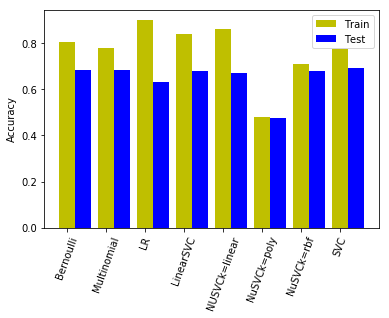

In [83]:
plt.clf()
fig, ax = plt.subplots()
width = 0.4
bar_train = ax.bar(range(len(errores)), list(derr.values()),width,color='y',align='center')

bar_test = ax.bar(np.arange(len(errores))+width, list(derr_t.values()),width,color='b', align='center')
plt.xticks(range(len(errores)), list(derr.keys()),rotation=70)
plt.ylabel("Accuracy")
ax.legend((bar_train[0], bar_test[0]), ('Train', 'Test'))
plt.show()

#### (g)	Utilice y explique las m´etricas que calcula la funci´on classification report de la librer´ıa sklearn. En base a las distintas m´etricas calculadas ¿Cu´ales clasificadores son los que mejor se comportan?

In [1]:
from sklearn.metrics import classification_report
def score_the_model(model,x,y,xt,yt,name,targets):
    acc_tr = model.score(x,y)
    acc_test = model.score(xt[:-1],yt[:-1])
    print ("%s Training Accuracy: %f"%(name,acc_tr))
    print ("%s Test Accuracy: %f"%(name,acc_test))
    print ("Detailed Analysis Testing Results ...")
    print (classification_report(yt, model.predict(xt),target_names=targets))


La función classification_report()calcula 4 métricas (precision, recall, f1-score, support).Donde el significado de precision es una indice entre los true positive y false positive, es decir representa la habilidad para clasificar correctamente las clases, algo parecido como se ve arriba con la matriz de confusión. El significado de recall tasa entre los true positive y el resto de las clases que no son el target ( true positive + false negative), esto representa la habilidad del clasificador en no dejar fuera los ejemplos de la clase propia, es decir, etiquetar correctamente los de la clase objetivo . f1-score realiza un promedio harmónico/ponderado entre las métricas de precision y recall , su dominio va de 0 a 1 con su mejor en 1. Finalmente support es el indice de la cantidad de ejemplos usados en la clase

In [85]:
score_the_model(bnb,Xtrain_tf,train_label,Xtest_tf,test_label,"Bernoulli Naive Bayes",["positivo","negativo"])

Bernoulli Naive Bayes Training Accuracy: 0.804759
Bernoulli Naive Bayes Test Accuracy: 0.686168
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.69      0.57      0.62      3611
   negativo       0.69      0.78      0.73      4321

avg / total       0.69      0.69      0.68      7932



In [86]:
score_the_model(mnb,Xtrain_tf,train_label,Xtest_tf,test_label,"Multinomial Naive Bayes",["positivo","negativo"])

Multinomial Naive Bayes Training Accuracy: 0.780965
Multinomial Naive Bayes Test Accuracy: 0.684655
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.70      0.53      0.61      3611
   negativo       0.68      0.81      0.74      4321

avg / total       0.69      0.68      0.68      7932



In [87]:
score_the_model(lr,Xtrain_tf,train_label,Xtest_tf,test_label,"Logistic Regresion",["positivo","negativo"])

Logistic Regresion Training Accuracy: 0.899775
Logistic Regresion Test Accuracy: 0.633842
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.61      0.56      0.58      3611
   negativo       0.65      0.70      0.67      4321

avg / total       0.63      0.63      0.63      7932



In [88]:
score_the_model(lsvm,Xtrain_tf,train_label,Xtest_tf,test_label,"Linear SVM",["positivo","negativo"])

Linear SVM Training Accuracy: 0.842429
Linear SVM Test Accuracy: 0.680368
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.67      0.59      0.63      3611
   negativo       0.69      0.75      0.72      4321

avg / total       0.68      0.68      0.68      7932



In [89]:
score_the_model(nusvm,Xtrain_tf,train_label,Xtest_tf,test_label,"No linear SVM kernel lineal",["positivo","negativo"])

No linear SVM kernel lineal Training Accuracy: 0.863571
No linear SVM kernel lineal Test Accuracy: 0.672677
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.66      0.58      0.62      3611
   negativo       0.68      0.75      0.71      4321

avg / total       0.67      0.67      0.67      7932



In [90]:
score_the_model(nusvmpoly,Xtrain_tf,train_label,Xtest_tf,test_label,"No linear SVM kernel poly",["positivo","negativo"])

No linear SVM kernel poly Training Accuracy: 0.479419
No linear SVM kernel poly Test Accuracy: 0.477872
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.47      0.98      0.63      3611
   negativo       0.81      0.05      0.10      4321

avg / total       0.65      0.48      0.34      7932



In [91]:
score_the_model(nusvmrbf,Xtrain_tf,train_label,Xtest_tf,test_label,"No linear SVM kernel rbf",["positivo","negativo"])

No linear SVM kernel rbf Training Accuracy: 0.710054
No linear SVM kernel rbf Test Accuracy: 0.678603
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

   positivo       0.68      0.56      0.61      3611
   negativo       0.68      0.78      0.72      4321

avg / total       0.68      0.68      0.67      7932



de f) y h) se puede ver que los mejores comportamientos los obtienen los clasificadores que no se apoyan en un kernel o usan kernel lineal. Esto se debe a que la mayoria de problemas de clasificación de texto son linealmente separable.

#### [Opcional] Visualice las predicciones de algu´n modelo generativo (probabil´ıstico) definido anteriormente, tomando un subconjunto aleatorio de tweets de pruebas y explorando las probabilidades que asigna el clasificador a cada clase.

In [93]:
import random
test_pred = lr.predict_proba(Xtest_tf)
spl = random.sample(range(len(test_pred)), 5)
for text, sentiment in zip(df.content[spl], test_pred[spl]):
    if(sentiment[0]>sentiment[1]):
        print ('[+]'+text)
    else:
        print ('[-]'+text)

[-]Whyyy am I still awake when I have to work at 8?! This is not good
[-]@Clumsyflic
[+]@LRon_Jaii :-S weirdo leave him alone
[-]@kevholditch It's NOT good.  1 of our directors said we could go home and the other said back to work  boo! It was good while it lasted.
[-]@mrcoups oh dear  not fun


#### (i)	Ahora deber´a extender el problema a las mu´ltiples clases que tiene presente (las distintas emociones), es decir, su trabajo ser´a el de predecir una de las distintas emociones de cada tweet. Para esto utilice el mismo pre-procesamiento realizado en el punto c) y las caracter´ısticas generadas mediante las t´ecnicas en el punto e). Recuerde que tendr´a que codificar las distintas clases como valores num´ericos enteros.

In [16]:
errs2_ = {}

In [17]:
df2 = df.sample(frac=1)
msk = np.random.rand(len(df2)) < 0.8
train2 = pd.DataFrame(df2[msk])
test2 = pd.DataFrame(df2[~msk])

neutral       6914
worry         6724
sadness       4179
happiness     4155
love          3048
surprise      1776
fun           1417
relief        1211
hate          1059
empty         661 
enthusiasm    608 
boredom       143 
anger         92  
Name: sentiment, dtype: int64


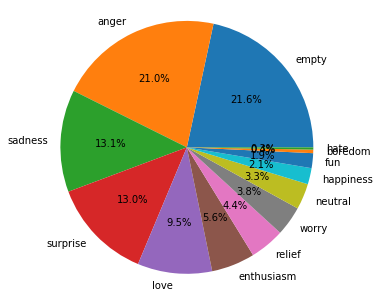

In [18]:
plt.clf()
sentiment_counts = train2['sentiment'].value_counts()
print (sentiment_counts)
#print list(set(df.sentiment.values))
plt.figure(figsize=(5,5))
plt.pie(sentiment_counts,labels=list(set(df.sentiment.values)),autopct='%1.1f%%')
plt.axis('equal')
plt.show()

In [19]:
train2['normalized_tweet'] = train2.content.apply(normalizer)
test2['normalized_tweet'] = test2.content.apply(normalizer)

In [20]:
dictionary = {"anger":1,"boredom":2,"empty":3,
              "enthusiasm":4,"fun":5,"happiness":6,
              "hate":7,"love":8,"neutral":9,"relief":10,
              "sadness":11,"surprise" : 12,"worry":13}
train2['sentiment'] = coding(train2['sentiment'],dictionary)
dictionary = {"anger":1,"boredom":2,"empty":3,
              "enthusiasm":4,"fun":5,"happiness":6,
              "hate":7,"love":8,"neutral":9,"relief":10,
              "sadness":11,"surprise" : 12,"worry":13}
test2['sentiment'] = coding(test2['sentiment'],dictionary)

In [21]:
traindata2 = [" ".join(x) for x in train2.normalized_tweet]
testdata2 = [" ".join(x) for x in test2.normalized_tweet]


train_label2 = train2.sentiment
test_label2 = test2.sentiment


In [22]:
count_vec2 = CountVectorizer(ngram_range=(1,2),lowercase = False)
count_vec2.fit(traindata2)

Xtrain2 = count_vec2.transform(traindata2)
Xtest2 = count_vec2.transform(testdata2)

In [23]:
tf_transformer2 = TfidfTransformer(use_idf=False).fit(Xtrain2)
Xtrain_tf2 = tf_transformer2.transform(Xtrain2)

Xtest_tf2 = tf_transformer2.transform(Xtest2)


#### (j)	Utilice los clasificadores que son extendidos por defecto a mu´ltiples clases para detectar emociones en cada tweet, muestre sus desempen˜os a trav´es del error de pruebas en un gr´afico resumen.

Bernoulli accuracy score
0.264944465244
Confusion matrix, without normalization


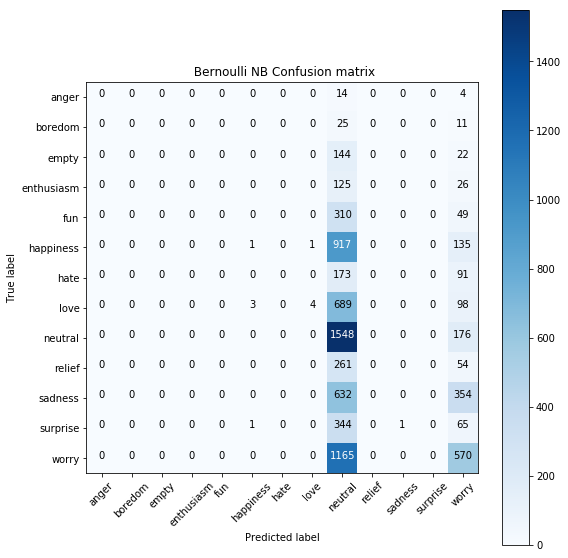

Multinomial Naive Bayes Training Accuracy: 0.414981
Multinomial Naive Bayes Test Accuracy: 0.264853
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

      anger       0.00      0.00      0.00        18
    boredom       0.00      0.00      0.00        36
      empty       0.00      0.00      0.00       166
 enthusiasm       0.00      0.00      0.00       151
        fun       0.00      0.00      0.00       359
  happiness       0.20      0.00      0.00      1054
       hate       0.00      0.00      0.00       264
       love       0.80      0.01      0.01       794
    neutral       0.24      0.90      0.38      1724
     relief       0.00      0.00      0.00       315
    sadness       0.00      0.00      0.00       986
   surprise       0.00      0.00      0.00       411
      worry       0.34      0.33      0.34      1735

avg / total       0.23      0.26      0.16      8013



C:\Python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [24]:
bnb2= BernoulliNB()
#fitting
bnb2.fit(Xtrain_tf2, train_label2)
#ypred
ypredBnb2 = bnb2.predict(Xtest_tf2)

print ('Bernoulli accuracy score')
print (accuracy_score(test_label2, ypredBnb2))

plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label2, ypredBnb2), 
                      classes=["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"],
                      title=' Bernoulli NB Confusion matrix')

plt.show()

score_the_model(bnb2,Xtrain_tf2,train_label2,Xtest_tf2,test_label2,"Multinomial Naive Bayes",
                ["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"])
errs2_["Bernoulli"] = errs_(bnb2,Xtrain_tf2,train_label2,Xtest_tf2,test_label2)

Bernoulli accuracy score
0.302633221016
Confusion matrix, without normalization


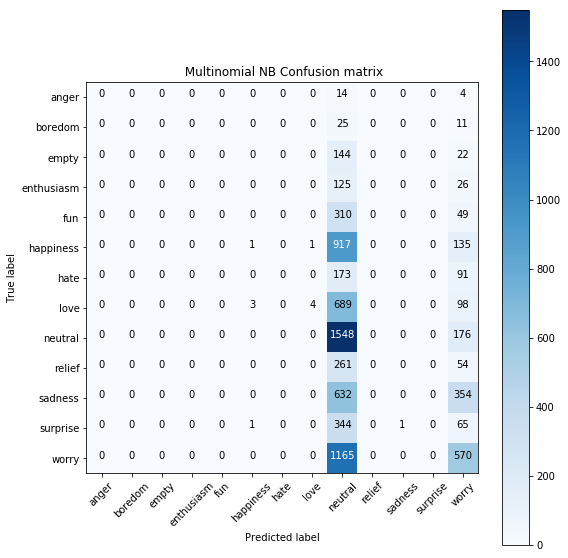

Multinomial Naive Bayes Training Accuracy: 0.472630
Multinomial Naive Bayes Test Accuracy: 0.302546
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

      anger       0.00      0.00      0.00        18
    boredom       0.00      0.00      0.00        36
      empty       0.00      0.00      0.00       166
 enthusiasm       0.00      0.00      0.00       151
        fun       0.00      0.00      0.00       359
  happiness       0.45      0.12      0.19      1054
       hate       0.00      0.00      0.00       264
       love       0.62      0.16      0.25       794
    neutral       0.30      0.49      0.37      1724
     relief       0.00      0.00      0.00       315
    sadness       0.38      0.01      0.02       986
   surprise       0.00      0.00      0.00       411
      worry       0.28      0.76      0.41      1735

avg / total       0.29      0.30      0.22      8013



C:\Python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [25]:
mnb2= MultinomialNB()
#fitting
mnb2.fit(Xtrain_tf2, train_label2)
#ypred
ypredMnb2 = mnb2.predict(Xtest_tf2)

print ('Bernoulli accuracy score')
print (accuracy_score(test_label2, ypredMnb2))

plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label2, ypredBnb2), 
                      classes=["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"],
                      title=' Multinomial NB Confusion matrix')

plt.show()
score_the_model(mnb2,Xtrain_tf2,train_label2,Xtest_tf2,test_label2,"Multinomial Naive Bayes",
                ["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"])
errs2_["Multinomial"] = errs_(mnb2,Xtrain_tf2,train_label2,Xtest_tf2,test_label2)

In [26]:
from sklearn.linear_model import LogisticRegression
C_array2 = [0.5,0.7,1,10,100,1000]
best2 = 0.0
c_b2 = 0.01
for C in C_array2:
    lr2 = LogisticRegression(penalty='l2',C=C)
    lr2.fit(Xtrain_tf2, train_label2)
    ypredlr2 = lr2.predict(Xtest_tf2)
    print ('Logistic Regression accuracy score C= %f'%C)
    acc2 = accuracy_score(test_label2, ypredlr2)
    print (acc2)
    if(acc2 > best2):
        best2 = acc2
        ypredlr_b2 = ypredlr2

Logistic Regression accuracy score C= 0.500000
0.346312242606
Logistic Regression accuracy score C= 0.700000
0.348308997878
Logistic Regression accuracy score C= 1.000000
0.351803319606
Logistic Regression accuracy score C= 10.000000
0.331960564083
Logistic Regression accuracy score C= 100.000000
0.301010857357
Logistic Regression accuracy score C= 1000.000000
0.286035192812


Confusion matrix, without normalization


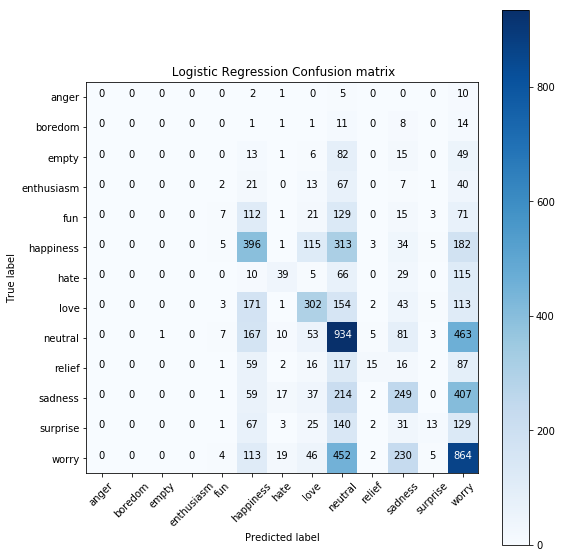

LR Training Accuracy: 0.538531
LR Test Accuracy: 0.351722
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

      anger       0.00      0.00      0.00        18
    boredom       0.00      0.00      0.00        36
      empty       0.00      0.00      0.00       166
 enthusiasm       0.00      0.00      0.00       151
        fun       0.23      0.02      0.04       359
  happiness       0.33      0.38      0.35      1054
       hate       0.41      0.15      0.22       264
       love       0.47      0.38      0.42       794
    neutral       0.35      0.54      0.42      1724
     relief       0.48      0.05      0.09       315
    sadness       0.33      0.25      0.29       986
   surprise       0.35      0.03      0.06       411
      worry       0.34      0.50      0.40      1735

avg / total       0.34      0.35      0.32      8013



C:\Python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [29]:
lr2 = LogisticRegression(penalty='l2',C=1)
lr2.fit(Xtrain_tf2, train_label2)
ypredlr2 = lr2.predict(Xtest_tf2)
plt.figure(figsize=(8,8))
plot_confusion_matrix(confusion_matrix(test_label2, ypredlr2), 
                      classes=["anger","boredom","empty","enthusiasm",
                               "fun","happiness","hate","love","neutral",
                               "relief","sadness","surprise","worry"],
                      title=' Logistic Regression Confusion matrix')

plt.show()

score_the_model(lr2,Xtrain_tf2,train_label2,Xtest_tf2,test_label2,"LR",["anger","boredom","empty","enthusiasm","fun","happiness","hate","love","neutral","relief","sadness","surprise","worry"])
errs2_["LR"] = errs_(lr2,Xtrain_tf2,train_label2,Xtest_tf2,test_label2)

#### (k)	Utilice clasificadores binarios que pueden ser extendidos a trav´es de otras t´ecnicas, tal como One vs One y One vs All/Rest 

In [27]:
from sklearn.multiclass import OneVsRestClassifier
clf1 = OneVsRestClassifier(LinearSVC(),n_jobs=3)
clf_output1 = clf1.fit(Xtrain_tf2, train_label2)

In [28]:
from sklearn.multiclass import OneVsOneClassifier
clf2 = OneVsOneClassifier(LinearSVC(),n_jobs=3)
clf_output2 = clf2.fit(Xtrain_tf2, train_label2)

In [111]:
# se demora mucho
#from sklearn.multiclass import OneVsOneClassifier
#clf3 = OneVsOneClassifier(SVC(gamma=0.2),n_jobs=3)
#clf_output3 = clf3.fit(Xtrain_tf2, train_label2)

In [30]:
score_the_model(clf1,Xtrain_tf2,train_label2,Xtest_tf2,test_label2,"One vs Rest",["anger","boredom","empty","enthusiasm","fun","happiness","hate","love","neutral","relief","sadness","surprise","worry"])

score_the_model(clf2,Xtrain_tf2,train_label2,Xtest_tf2,test_label2,"One vs One",["anger","boredom","empty","enthusiasm","fun","happiness","hate","love","neutral","relief","sadness","surprise","worry"])
#score_the_model(clf3,Xtrain_tf2,train_label2,Xtest_tf2,test_label2,"One vs One",["anger","boredom","empty","enthusiasm","fun","happiness","hate","love","neutral","relief","sadness","surprise","worry"])
errs2_["clf1"] = errs_(clf1,Xtrain_tf2,train_label2,Xtest_tf2,test_label2)
errs2_["clf2"] = errs_(clf2,Xtrain_tf2,train_label2,Xtest_tf2,test_label2)

One vs Rest Training Accuracy: 0.960640
One vs Rest Test Accuracy: 0.324139
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

      anger       0.00      0.00      0.00        18
    boredom       0.17      0.03      0.05        36
      empty       0.13      0.02      0.04       166
 enthusiasm       0.00      0.00      0.00       151
        fun       0.17      0.05      0.07       359
  happiness       0.31      0.37      0.34      1054
       hate       0.34      0.20      0.25       264
       love       0.43      0.41      0.42       794
    neutral       0.35      0.43      0.39      1724
     relief       0.22      0.07      0.10       315
    sadness       0.26      0.29      0.28       986
   surprise       0.16      0.06      0.09       411
      worry       0.33      0.42      0.37      1735

avg / total       0.30      0.32      0.30      8013

One vs One Training Accuracy: 0.939694
One vs One Test Accuracy: 0.340864
Detailed Analy

C:\Python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### (l) Para el caso de la Regresi´on Log´ıstica compare sus dos m´etodos para ser extendidos a mu´ltiples clases. Uno a trav´es de One vs Rest y otro definiendo que la variable a predecir se distribuye Multinomial.

In [31]:
lr3 = LogisticRegression(multi_class='ovr',n_jobs=3).fit(Xtrain_tf2, train_label2)
ypredlr3 = lr3.predict(Xtest_tf2)
errs2_["LR_ovr"] = errs_(lr3,Xtrain_tf2,train_label2,Xtest_tf2,test_label2)

C:\Python36\lib\site-packages\sklearn\linear_model\logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 3.
  " = {}.".format(self.n_jobs))


In [32]:
lr4 = LogisticRegression(multi_class='multinomial',solver='sag',n_jobs=3).fit(Xtrain_tf2, train_label2)
ypredlr4 = lr4.predict(Xtest_tf2)
errs2_["LR_multinomial"] = errs_(lr3,Xtrain_tf2,train_label2,Xtest_tf2,test_label2)

In [33]:
score_the_model(lr3,Xtrain_tf2,train_label2,Xtest_tf2,test_label2,"LogisticRegression One vs Rest",
                ["anger","boredom","empty","enthusiasm",
                "fun","happiness","hate","love","neutral",
                "relief","sadness","surprise","worry"])
score_the_model(lr4,Xtrain_tf2,train_label2,Xtest_tf2,test_label2,"LogisticRegression One vs One",
                ["anger","boredom","empty","enthusiasm",
                "fun","happiness","hate","love","neutral",
                "relief","sadness","surprise","worry"])

LogisticRegression One vs Rest Training Accuracy: 0.538531
LogisticRegression One vs Rest Test Accuracy: 0.351722
Detailed Analysis Testing Results ...
             precision    recall  f1-score   support

      anger       0.00      0.00      0.00        18
    boredom       0.00      0.00      0.00        36
      empty       0.00      0.00      0.00       166
 enthusiasm       0.00      0.00      0.00       151
        fun       0.23      0.02      0.04       359
  happiness       0.33      0.38      0.35      1054
       hate       0.41      0.15      0.22       264
       love       0.47      0.38      0.42       794
    neutral       0.35      0.54      0.42      1724
     relief       0.48      0.05      0.09       315
    sadness       0.33      0.25      0.29       986
   surprise       0.35      0.03      0.06       411
      worry       0.34      0.50      0.40      1735

avg / total       0.34      0.35      0.32      8013

LogisticRegression One vs One Training Accuracy: 0

C:\Python36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


#### (m) Compare los resultados entre los clasificadores extendidos por defecto y los binarios que son extendidos mediante otras t´ecnicas, construya una tabla o gr´afico resumen. Los clasificadores que mejor se comportan en el caso binario ¿Siguen teniendo ese desempen˜o en mu´ltiples clases?

In [35]:
derr2 = {}
derr_t2 = {}
for k,v in errs2_.items():
    values2 = list(v)
    derr2[k] = values2[0]
    derr_t2[k] = values2[1]

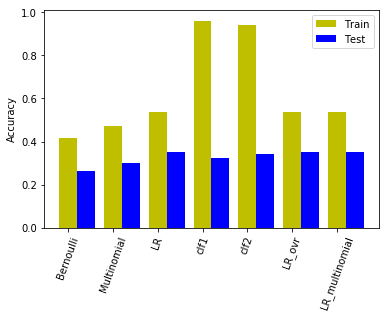

In [36]:
plt.clf()
fig, ax = plt.subplots()
width = 0.4
bar_train = ax.bar(range(len(errs2_)), list(derr2.values()),width,color='y',align='center')

bar_test = ax.bar(np.arange(len(errs2_))+width, list(derr_t2.values()),width,color='b', align='center')
plt.xticks(range(len(errs2_)), list(derr2.keys()),rotation=70)
plt.ylabel("Accuracy")
ax.legend((bar_train[0], bar_test[0]), ('Train', 'Test'))
plt.show()

In [37]:
#clf1 y clf2 son LinearSVC()

Algoritmos que tenia relativamente buenos resultados al ser extendidos a mutiples clases se ven afectados (naive bayes) y LR simple tambien disminuyo en comparacion al caso anterior. Pero con metodos como ovo y ovr se comporto igual. En cambio al usar ovo y ovr con una SVM lineal se obtuvo un gran accuracy de entrenamiento, lo que sugiere un sobre ajuste, aun asi el accuracy en el caso de prueba fue pobre en todos los caso y siempre menor que el entrenamiento. 
Se intento mejorar los resultados mediante homogenizacion de los datos (cada sentimiento en un % similar) pero disminuyo el accuracy contrario a lo que el sentido comun ordinario diria, pero esto se puede explicar facilmente debido a que las maquinas aprenden mejor entre mas datos de un tipo tienen, asi pueden generalizar mejor lo que significa una etiqueta en particular.